In [2]:
import pandas as pd
from mphelper import ProcessWrapPool
from biodatatools.utils.common import json_load
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from collections import Counter
from statsmodels.stats.multitest import multipletests
import re
from openpyxl import load_workbook
import sys
import copy

In [3]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [4]:
sys.path.append(str(Path.cwd().parent))
import utils

In [5]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/homer/"

# Hierarchical clustering

In [6]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [7]:
# K562: equivalent to hematopoietic stem/progenitor
# B-ALL: equivalent to pro/pre-B
# GCB-DLBCL: equivalent to germinal center B cell

samples = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")["leukemia_lymphoma"]
samples = [s for s in samples if s != "SP49"]
len(samples)

8

In [8]:
p = "divergent"
d = "distal"
inputfile = f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt"
df_es = pd.read_table(inputfile, index_col=0)
es = list(df_es[df_es[list(samples)].sum(axis=1) >= 1].index)

In [9]:
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
df_exp = df_exp[samples].loc[es]

In [10]:
def plot_dendrogram(linkage, labels):
    fig, ax = plt.subplots(figsize=(1,3))
    dendro = sch.dendrogram(linkage, labels=labels, leaf_rotation=0, orientation="left", color_threshold=0, above_threshold_color='grey') 
    
    plt.gca().invert_yaxis()
    ax.spines[['top','bottom','left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=bfontsize)

    return dendro

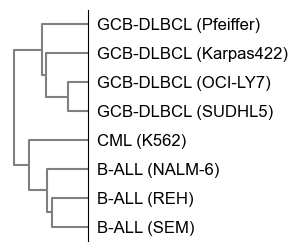

In [11]:
pca = PCA(n_components=0.9, random_state=42)
data = pca.fit_transform(df_exp.T)
linkage = sch.linkage(data, metric='euclidean', method='ward')
labs = [f"{labels[s][1]} ({s})" for s in df_exp.T.index]
_ = plot_dendrogram(linkage, labs)

In [12]:
# For better visualization, we can flip CML with B-ALL cell lines
# For more info, please check https://stackoverflow.com/questions/56259202/reordering-the-high-level-clusters-from-seaborn-clustermap-results/
# get actual sample names
# Locate which branch you'd like to flip

In [13]:
def check_linkage(linkage):
    i = 0
    for col in linkage:
        n1, n2, d, n = list(col)
        if int(n1) <= len(samples)-1:
            n1 = samples[int(n1)]
        else:
            n1 = int(n1) - len(samples)
        if int(n2) <= len(samples)-1:
            n2 = samples[int(n2)]
        else:
            n2 = int(n2) - len(samples)
        print(i, n1, n2, d, n)
        i += 1

In [14]:
check_linkage(linkage)

0 OCI-LY7 SUDHL5 200.7033932493839 2.0
1 REH SEM 361.7289857133555 2.0
2 NALM-6 1 410.7062211275575 3.0
3 Karpas422 0 418.91709198378163 3.0
4 Pfeiffer 3 455.3526545748806 4.0
5 K562 2 594.675501819633 4.0
6 4 5 744.3515681694333 8.0


In [15]:
def switch_branch(x):
    b1, b2, score, n = x.tolist()[0]
    new = [[b2, b1, score, n]]
    return np.array(new)

In [16]:
nodes = [0,5]
linkage2 = copy.deepcopy(linkage)
for n in nodes:
    linkage2[[n]] = switch_branch(linkage2[[n]])

In [17]:
check_linkage(linkage2)

0 SUDHL5 OCI-LY7 200.7033932493839 2.0
1 REH SEM 361.7289857133555 2.0
2 NALM-6 1 410.7062211275575 3.0
3 Karpas422 0 418.91709198378163 3.0
4 Pfeiffer 3 455.3526545748806 4.0
5 2 K562 594.675501819633 4.0
6 4 5 744.3515681694333 8.0


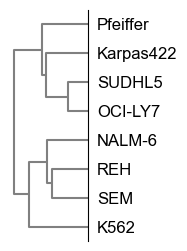

In [18]:
# Check the tree structure

dendro = plot_dendrogram(linkage2, list(df_exp.T.index))

In [19]:
# Will display the tree from left to right

sample_order = dendro["ivl"][::-1]
sample_order

['K562', 'SEM', 'REH', 'NALM-6', 'OCI-LY7', 'SUDHL5', 'Karpas422', 'Pfeiffer']

# TRE modules

In [20]:
# Use K-means clustering to identify TRE modules

random_state = 42
df_zscore = df_exp.apply(lambda x: zscore(x), axis=1)
data = df_zscore.values
wcss = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

In [21]:
kmeans = KMeans(n_clusters=10, random_state=random_state)
kmeans.fit(data)

KMeans(n_clusters=10, random_state=42)

In [22]:
df_cluster = df_zscore[sample_order].copy()
df_cluster['cluster'] = kmeans.labels_
df_cluster = df_cluster.sort_values(by="cluster")
df_cluster.head(2)

,K562,SEM,REH,NALM-6,OCI-LY7,SUDHL5,Karpas422,Pfeiffer,cluster
chr5_151124125_151124607,-0.944645,-0.898245,-1.091542,-0.307151,0.729331,1.955913,0.779527,-0.223186,0
chr5_151125516_151125715,-0.974841,-0.974841,-0.783462,-0.124664,0.363459,1.911502,1.161544,-0.578696,0


In [23]:
def plot_heatmap(df, vlims=[-2,0,2]):
    fig, ax = plt.subplots(figsize=(4,3))
    g = sns.heatmap(df, xticklabels=True, yticklabels=False,
                   vmin=vlims[0], vmax=vlims[-1],
                   cmap="viridis", ax=ax)

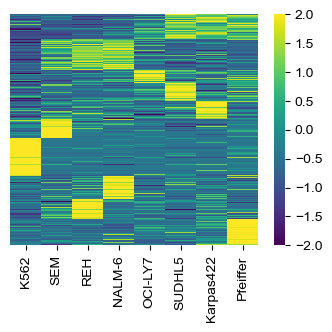

In [24]:
# Check if TRE modules are listed in a desired order

plot_heatmap(df_cluster[df_cluster.columns[:-1]])

In [25]:
custom_order = [6,
                1, 5, 8, 7,
                0, 2, 3, 4, 9
                ]
# 1-based
cluster_map = {cluster: idx + 1 for idx, cluster in enumerate(custom_order)}
df_cluster_sorted = df_cluster.copy()
df_cluster_sorted['new_cluster'] = df_cluster_sorted['cluster'].map(cluster_map)
df_cluster_sorted = df_cluster_sorted.sort_values(by="new_cluster")
df_cluster_sorted = df_cluster_sorted.drop("cluster", axis=1)
df_cluster_sorted.head(2)

,K562,SEM,REH,NALM-6,OCI-LY7,SUDHL5,Karpas422,Pfeiffer,new_cluster
chr15_90149125_90149801,2.226240,-0.723226,-0.111063,-0.723226,-0.723226,-0.175433,-0.723226,0.953161,1
chr15_90158138_90158540,1.711764,-0.455067,-1.022793,-0.111884,-1.321939,1.235056,-0.532666,0.497529,1


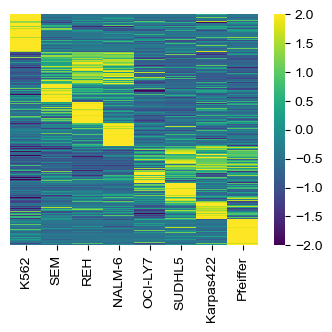

In [26]:
plot_heatmap(df_cluster_sorted[df_cluster_sorted.columns[:-1]])

In [27]:
Counter(df_cluster_sorted["new_cluster"])

Counter({1: 8863,
         2: 7304,
         10: 6060,
         6: 5631,
         5: 5284,
         4: 4770,
         9: 4332,
         3: 4274,
         8: 4192,
         7: 2972})

In [28]:
outputfile = f"{PROJECT_DIR_d}PROcap/processed/LL_modules.bed"
df_cluster_sorted.to_csv(outputfile, sep="\t")

In [29]:
subtypes = {}
colors = {}
palettes = {}
color_vectors = {}

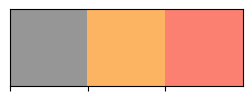

In [30]:
subtypes = ["CML", "B-ALL", "GCB-DLBCL"]
colors = ["#969696", "#fdb462", "#fb8072"]
palettes = sns.color_palette(colors)
sns.palplot(palettes)

In [31]:
results = [[colors[subtypes.index(labels[s][1])]] for s in sample_order]
df_colors = pd.DataFrame(results, index=sample_order, columns=[""])
df_colors

,
K562,#969696
SEM,#fdb462
REH,#fdb462
NALM-6,#fdb462
OCI-LY7,#fb8072
SUDHL5,#fb8072
Karpas422,#fb8072
Pfeiffer,#fb8072


In [32]:
cytogenetics = {"K562": "BCR-ABL",
                # https://www.cellosaurus.org/CVCL_HE09
                "NALM-6": "IGH-DUX4",
                # https://www.cellosaurus.org/CVCL_1650
                "REH": "ETV6-RUNX1",
                # https://www.cellosaurus.org/CVCL_0095
                "SEM": "KMT2A-AFF1",
                # https://www.mdpi.com/1422-0067/25/4/2377
                "Pfeiffer": "BCL2-IGH",         
                # https://www.culturecollections.org.uk/nop/product/karpas-422
                # https://www.biorxiv.org/content/10.1101/2023.05.02.538892v1
                "Karpas422": "BCL2-IGH; MYC 3' enhancer",
                # https://www.biorxiv.org/content/10.1101/2023.05.02.538892v1
                "SUDHL5": "MYC 3' enhancer",
                # https://www.cellosaurus.org/CVCL_1881
                "OCI-LY7": "MYC-IGH"
               }

In [33]:
# Only show the average Z-score for each TRE module

df_avg = df_cluster_sorted.groupby("new_cluster").mean()
df_avg.index = [f"M{n}" for n in df_avg.index]
df_avg.head(2)

,K562,SEM,REH,NALM-6,OCI-LY7,SUDHL5,Karpas422,Pfeiffer
M1,2.314562,-0.334215,-0.370458,-0.407508,-0.365758,-0.378820,-0.277993,-0.179811
M2,-0.848980,0.559332,1.261321,1.270618,-0.516690,-0.573907,-0.543472,-0.608222


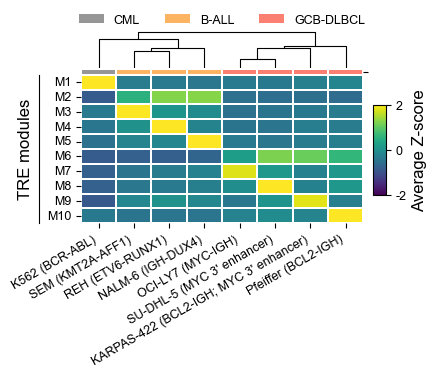

In [34]:
vlims = [-2,0,2]
g = sns.clustermap(df_avg, 
                   col_colors=df_colors,
                   yticklabels=True,
                   xticklabels=True, 
                   row_cluster=False,
                   col_cluster=False,
                   linewidths=0.1,
                   vmin=vlims[0], vmax=vlims[-1],
                   cmap="viridis", figsize=(4.2,3))

axy = g.ax_col_dendrogram.axes
with plt.rc_context({'lines.linewidth': lw}):
    sch.dendrogram(linkage2, 
           color_threshold=0, 
           ax=axy,
           orientation='top',
           link_color_func=lambda x: 'k'
          )
axy.invert_xaxis()

for label in subtypes:
    i = subtypes.index(label)
    g.ax_col_dendrogram.bar(0, 0, color=palettes[i],
                            label=label, 
                            linewidth=0)
g.ax_col_dendrogram.legend(fontsize=sfontsize, ncol=3, frameon=False,
                           loc="upper center", bbox_to_anchor=(0.5,1.7))

g.ax_heatmap.set_xticklabels([f"{labels[s][0]} ({cytogenetics[s]})" for s in df_avg.columns])
for label in g.ax_heatmap.get_xticklabels():
    label.set_rotation(30)
    label.set_ha("right")

g.ax_heatmap.yaxis.tick_left()
g.ax_heatmap.set_ylabel("TRE modules", fontsize=bfontsize, labelpad=10)
g.ax_heatmap.yaxis.set_label_position("left")
line_x = -0.15
g.ax_heatmap.plot([line_x, line_x], [0, 1], transform=g.ax_heatmap.transAxes, color='black', clip_on=False, lw=lw)
for label in g.ax_heatmap.get_yticklabels():
    label.set_rotation(0)

g.tick_params(labelsize=sfontsize)

g.cax.set_visible(False)
cbar_ax = g.fig.add_axes([0.9, 0.4, 0.03, 0.3])
cbar = plt.colorbar(g.ax_heatmap.collections[0], cax=cbar_ax)
cbar.set_ticks(vlims)
cbar.set_ticklabels(vlims)
cbar.ax.tick_params(labelsize=sfontsize) 
cbar.set_label("Average Z-score", fontsize=bfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig6a.pdf", bbox_inches="tight", transparent=True)

# Motif enrichment

## De novo motif discovery

In [35]:
# Use all divergent distal elements as background

outputfile = f"{PROJECT_DIR_o}homer/LL/bg.bed"
utils.generate_homer_input(es, outputfile)

In [36]:
n_clusters = len(set(df_cluster_sorted["new_cluster"]))

In [37]:
for m in range(1,n_clusters+1):
    outputfile = f"{PROJECT_DIR_o}homer/LL/M{m}.bed"
    utils.generate_homer_input(list(df_cluster_sorted[df_cluster_sorted["new_cluster"]==m].index), outputfile)

In [38]:
ms = [f"M{n}" for n in range(1,n_clusters+1)]

In [46]:
pwpool = ProcessWrapPool(len(ms))

bg = f"{PROJECT_DIR_o}homer/LL_bg.bed"
for m in ms:
	target = f"{PROJECT_DIR_o}homer/LL/{m}.bed"
	outdir = f"{PROJECT_DIR_o}homer/LL/{m}"
	pwpool.run(utils.run_homer, args=[PROJECT_DIR_s, target, bg, outdir])


	Position file = /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_M2.bed
	Genome = hg38
	Output Directory = /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_M2
	Using actual sizes of regions (-size given)
	Fragment size set to given
	background position file: /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_bg.bed
	Found mset for "human", will check against vertebrates motifs

	Position file = /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_M4.bed
	Genome = hg38
	Output Directory = /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_M4
	Using actual sizes of regions (-size given)
	Fragment size set to given
	background position file: /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/homer/LL_bg.bed
	Found mset for "human", will check against vertebrates motifs


In [54]:
# len(pwpool.finished_tasks)

In [55]:
pwpool.close()

In [15]:
# Write the content of all motifs in "homerResults.html"

outputfile = f"{PROJECT_DIR_o}supp_tables/SuppTable3.xlsx"
book = load_workbook(outputfile)
with pd.ExcelWriter(outputfile, engine='openpyxl', mode='a', if_sheet_exists='replace') as f:
	for m in ms:
		html = f"{PROJECT_DIR_o}homer/LL/{m}/homerResults.html"
		df = pd.read_html(html, header=0)[0]
		columns_keep = [c for c in df.columns if c not in ["Motif", "Motif File"]]
		df = df[columns_keep]
		df = df[~df["Rank"].astype(str).str.contains(r"\*", na=False)]
		df.to_excel(f, sheet_name=f"LL-{m}", index=False)

## Custom motif enrichment

In [39]:
# Combine biologically relevant motifs in each module as custom-known motif file for motif enrichment
# SNAI1 (ZF, mostly not expressed in DLBCL); ZEB1 (same motif and pattern)
# SUDHL5 is one of the DLBCL cell lines with the lowest NF-kB gene activation signatures; Pfeiffer is very high.

motifs_keep = { # K562
                "M1": ['1-BCTTATCTSN,BestGuess:Gata6(Zf)/HUG1N-GATA6-ChIP-Seq(GSE51936)/Homer(0.983)'],
                # B-ALL
                "M2": ['3-TCCCCHGGGG,BestGuess:EBF1(EBF)/Near-E2A-ChIP-Seq(GSE21512)/Homer(0.927)'], 
                # SEM
                "M3": ['1-ATGTGGTT,BestGuess:RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer(0.951)'],
                # REH
                "M4": ['1-AAGGAAGGAAGG,BestGuess:EWSR1-FLI1/MA0149.1/Jaspar(0.825)'],
                # NALM-6
                "M5": ['1-NTAAYYYAATCA,BestGuess:DUX4/MA0468.1/Jaspar(0.967)'],
                # GCB-DLBCL & SUDHL5 & KARPAS-422
                "M6": ['1-WTATGCAAATNW,BestGuess:POU2F3/MA0627.3/Jaspar(0.969)'],
                # Pfeiffer
                "M10": ['2-KGGAAWTTCC,BestGuess:RELA/MA0107.1/Jaspar(0.927)',
                        '1-CACACCTG,BestGuess:ZEB2(Zf)/SNU398-ZEB2-ChIP-Seq(GSE103048)/Homer(0.951)']
                }

In [40]:
def extract_motif_by_annotation(inputfile, motif):
    motif_lines = []
    with open(inputfile, 'r') as f:
        found = False
        for line in f:
            if line.startswith('>'):
                if motif in line:
                    found = True
                    motif_lines = [line.rstrip()]
                else:
                    if found:
                        break
            elif found:
                motif_lines.append(line.rstrip())
    return motif_lines

In [41]:
lines_keep = []
for m in motifs_keep:
    for motif in motifs_keep[m]:
        inputfile = f"{PROJECT_DIR_o}homer/LL/{m}/nonRedundant.motifs"
        lines_keep.extend(extract_motif_by_annotation(inputfile, motif))

In [42]:
outputfile = f"{PROJECT_DIR_o}homer/LL/top.motifs"
with open(outputfile, "w") as f:
    for line in lines_keep:
        f.write(f"{line}\n")

In [1]:
pwpool = ProcessWrapPool(len(ms))

motif_file = f"{PROJECT_DIR_o}homer/LL_TRE_modules.motifs"
denovo = False
for m in ms:
	target = f"{PROJECT_DIR_o}homer/LL_{m}.bed"
	outdir = f"{PROJECT_DIR_o}homer/LL_{m}_top"
	pwpool.run(utils.run_homer, args=[PROJECT_DIR_s, target, bg, outdir, motif_file, denovo])

In [53]:
# len(pwpool.finished_tasks)

In [85]:
pwpool.close()

## Heatmap

In [43]:
ms2 = [m for m in ms if m not in ["M2", "M6"]]

In [45]:
# Get one combined dataframe
# row: sample
# column: all motifs

results = []
index = []
motifs = [motif for m in motifs_keep for motif in motifs_keep[m]]
for m in ms:
    df = pd.read_table(f"{PROJECT_DIR_o}homer/LL/{m}_top/knownResults.txt")
    df["Motif Name"] = pd.Categorical(df["Motif Name"], categories=motifs, ordered=True)
    df = df.sort_values("Motif Name")
    results.append([pvalue for pvalue in list(df["P-value"])])
    if m not in ["M2", "M6"]:
        index.append(f"{m} ({sample_order[ms2.index(m)]})")
    else:
        index.append(m)

df_pvalues = pd.DataFrame(results, columns=motifs, index=index)
df_pvalues.head(2)

,"1-BCTTATCTSN,BestGuess:Gata6(Zf)/HUG1N-GATA6-ChIP-Seq(GSE51936)/Homer(0.983)","3-TCCCCHGGGG,BestGuess:EBF1(EBF)/Near-E2A-ChIP-Seq(GSE21512)/Homer(0.927)","1-ATGTGGTT,BestGuess:RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer(0.951)","1-AAGGAAGGAAGG,BestGuess:EWSR1-FLI1/MA0149.1/Jaspar(0.825)","1-NTAAYYYAATCA,BestGuess:DUX4/MA0468.1/Jaspar(0.967)","1-WTATGCAAATNW,BestGuess:POU2F3/MA0627.3/Jaspar(0.969)","2-KGGAAWTTCC,BestGuess:RELA/MA0107.1/Jaspar(0.927)","1-CACACCTG,BestGuess:ZEB2(Zf)/SNU398-ZEB2-ChIP-Seq(GSE103048)/Homer(0.951)"
M1 (K562),0.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
M2,1.0,1.000000e-62,1.000000e-38,1.0,1.0,1.0,1.0,1.0


In [46]:
# FDR correction

min_nonzero = 1e-300
df_pvalues_float = df_pvalues.clip(lower=min_nonzero)
flat_pvals = df_pvalues_float.values.flatten()
_, fdr_corrected, _, _ = multipletests(flat_pvals, method='fdr_bh')
df_fdr = pd.DataFrame(
                    fdr_corrected.reshape(df_pvalues.shape),
                    index=df_pvalues.index,
                    columns=df_pvalues.columns
                    )
df_log_fdr = -np.log10(df_fdr)

In [47]:
new_names = []
for t in df_pvalues.columns:
    if "EWSR1-FLI1" in t:
        name = "(GGAA)n"
    elif "DUX4" in t:
        name = "DUX4"
    elif "ZEB" in t:
        name = "ZEB1"
    else:
        name = t.split(":")[1].split("/")[0].split("(")[0]
        if name in ["Gata6", "RUNX2", "POU2F3"]:
            name = name[:-1].upper()
    new_names.append(name)
df_log_fdr.columns = new_names

In [48]:
motif_order = ["GATA", "EBF1", "RUNX", "(GGAA)n", "DUX4", "ZEB1", "POU2F", "RELA"]
df_log_fdr = df_log_fdr[motif_order]

In [49]:
df_mask = df_log_fdr > -np.log10(0.05)
df_annot = df_mask.astype(str).replace({'True': '*', 'False': ''})

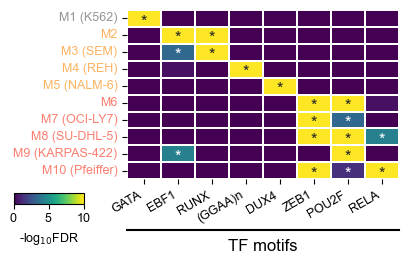

In [55]:
fig, ax = plt.subplots(figsize=(3.5,2.2))
vlims = [0,5,10]
g = sns.heatmap(df_log_fdr, vmin=vlims[0], vmax=vlims[-1], linewidths=0.2,
               annot=df_annot, annot_kws={"size": bfontsize}, fmt="s",
               cmap="viridis", ax=ax)
for text in g.texts:
    x, y = text.get_position()
    text.set_position((x, y + 0.2))

# for ticklabel in g.get_yticklabels():
#     ticklabel.set_color('white')
# yticklabels = g.get_yticklabels()
# yticks = g.get_yticks()
# for n in range(len(yticks)):
#   match = re.match(r'([^\(]+) \(([^\)]+)\)', yticklabels[n].get_text())
#   module = match.group(1).strip()
#   sample = match.group(2).strip()
#   ls = [module, " (", labels[sample][0], ")"]
#   lc = ["black", "black", colors[subtypes.index(labels[sample][1])], "black"]
#   utils.rainbow_text(x=-0.3, y=yticks[n], ls=ls, lc=lc, ax=ax,
#                   va="center", fontsize=bfontsize)

yticklabels_new = []
ytick_colors = []
for label in g.get_yticklabels():
    if label.get_text() in ["M2", "M6"]:
        yticklabels_new.append(label.get_text())
        color = colors[1] if label.get_text() == "M2" else colors[2]
        ytick_colors.append(color)
    else:
        match = re.match(r'([^\(]+) \(([^\)]+)\)', label.get_text())
        module = match.group(1).strip()
        s = match.group(2).strip()
        s2 = labels[s][0]
        yticklabels_new.append(f"{module} ({s2})")
        ytick_colors.append(colors[subtypes.index(labels[s][1])])
g.set_yticklabels(yticklabels_new, fontsize=sfontsize)
for lbl, c in zip(g.get_yticklabels(), ytick_colors):
    lbl.set_color(c)

g.tick_params(axis="x", labelsize=sfontsize, rotation=30)
for label in g.get_xticklabels():
    label.set_ha("right")
line_y = -0.3
g.plot([0, 1], [line_y, line_y], transform=g.transAxes, color='black', clip_on=False)
ax.set_xlabel("TF motifs", fontsize=bfontsize, labelpad=10)

g.collections[0].colorbar.remove()
cbar_ax = fig.add_axes([-0.2, 0, 0.2, 0.05])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(vlims)
cbar.set_ticklabels(vlims)
cbar.ax.tick_params(labelsize=sfontsize) 
cbar.set_label("-log$_{10}$FDR", fontsize=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig9a.pdf", bbox_inches="tight", transparent=True)